In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import logistic
from scipy.special import logit

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt


# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.continous import *
from utils.sampling_tram_data import *

Train with GPU support.
No GPU found, train with CPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "interactions"   ## <--- set experiment name
seed=42
np.random.seed(seed)

DATA_PATH = "/home/bule/TramDag/data"
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
os.makedirs(EXPERIMENT_DIR,exist_ok=True)

# 2.  Data

In [3]:


# TODO develop meaningful experiment for interactions



# Fz(z)=Fy(y)
# Fz(h(y|x))=Fy(y)    | z= h(y|x)

# Generate x2

# h(y|x1,x2,x3,x4,x5)= Bernsteinpol(x1,x2) +f2(x2,x3) + f3(x4, x2) + beta * x5        | bernsteinpol is just linearized assumed with a constant factor say 0.42
# h(y|x1,x2,x3,x4,x5)= Bernsteinpol(x1,x2) +f2(x2,x3) + f3(x4, x2) + beta * x5                                          | replace h(y|..) with z
# z                  = 0.42*x2 + beta2 * x1                                           | reformulate to x2
# x2                 = (z-beta2 * x1 )/0.42                                           | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
# x2                 = (z-beta2 * x1 )/0.42                                           | set beta = 2 (on the edge of the graph)
# x2                 = (z-2 * x1 )/0.42           

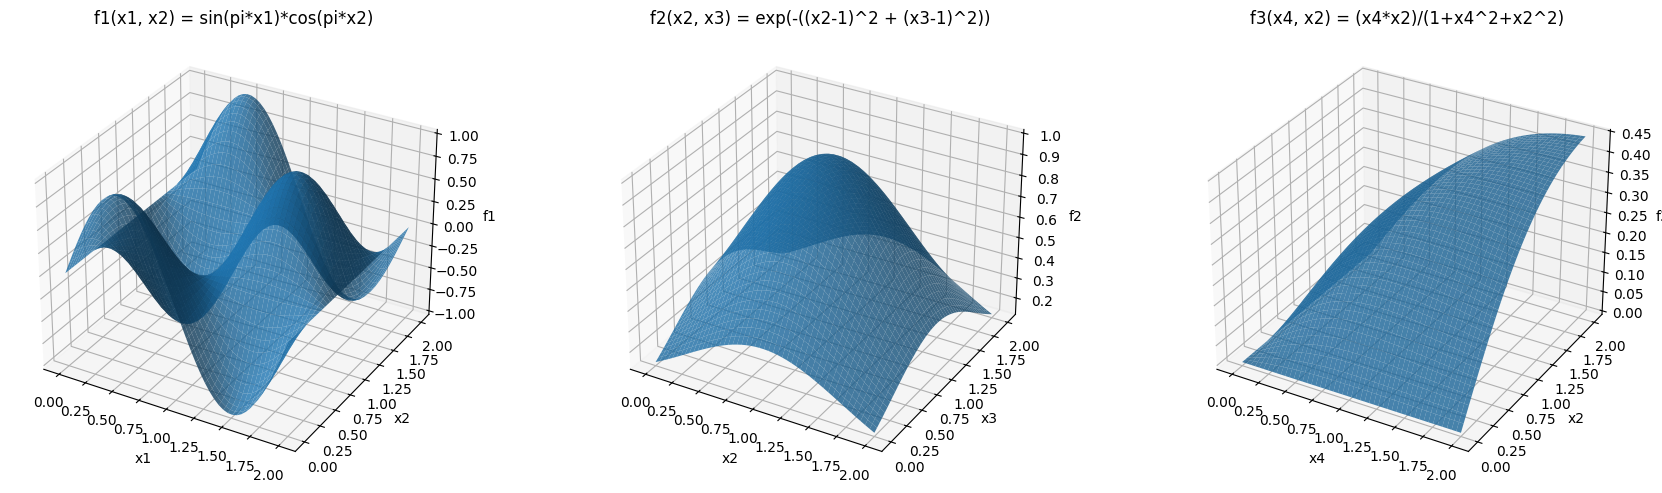

In [4]:
from scipy.special import logit
from mpl_toolkits.mplot3d import Axes3D


# Define the functions used in the DGP
def f1(x1, x2):
    return np.sin(np.pi * x1) * np.cos(np.pi * x2)

def f2(x2, x3):
    return np.exp(-((x2 - 1)**2 + (x3 - 1)**2))

def f3(x4, x2):
    return (x4 * x2) / (1 + x4**2 + x2**2)

def dgp_continuous_interactions(n_obs=10_000, seed=42):
    np.random.seed(seed)

    # Independent variables
    x1 = np.random.uniform(0, 2, size=n_obs)
    x2 = np.random.uniform(0, 2, size=n_obs)
    x3 = np.random.uniform(0, 2, size=n_obs)
    x4 = np.random.uniform(0, 2, size=n_obs)
    x5 = np.random.normal(0, 1, size=n_obs)
    x6 = np.random.uniform(0, 2, size=n_obs)
    x7 = np.random.normal(0, 1, size=n_obs)

    # Response variable with interactions
    y = f1(x1, x2) + f2(x3, x4) + f3(x5, x6) + 1.5 * x7

    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5, 'x6': x6, 'x7': x7, 'x8': y})
    return df

# Generate data
df = dgp_continuous_interactions()

# Visualize the 3 interaction functions
fig = plt.figure(figsize=(18, 5))

# f1(x1, x2)
ax = fig.add_subplot(131, projection='3d')
x = np.linspace(0, 2, 50)
y = np.linspace(0, 2, 50)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f1(x1, x2) = sin(pi*x1)*cos(pi*x2)")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("f1")

# f2(x2, x3)
ax = fig.add_subplot(132, projection='3d')
X, Y = np.meshgrid(x, y)
Z = f2(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f2(x2, x3) = exp(-((x2-1)^2 + (x3-1)^2))")
ax.set_xlabel("x2")
ax.set_ylabel("x3")
ax.set_zlabel("f2")

# f3(x4, x2)
ax = fig.add_subplot(133, projection='3d')
X, Y = np.meshgrid(x, y)
Z = f3(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f3(x4, x2) = (x4*x2)/(1+x4^2+x2^2)")
ax.set_xlabel("x4")
ax.set_ylabel("x2")
ax.set_zlabel("f3")

plt.tight_layout()
plt.show()

## 2.1 train test split

In [5]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

# 3. Normalize all sets using training quantiles
def normalize_with_quantiles(df, min_vals, max_vals):
    return (df - min_vals) / (max_vals - min_vals)

# train_df = normalize_with_quantiles(train_df, min_vals, max_vals)
# val_df = normalize_with_quantiles(val_df, min_vals, max_vals)
# test_df = normalize_with_quantiles(test_df, min_vals, max_vals)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 8000, Validation size: 1000, Test size: 1000


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


Found existing matrix at /home/bule/TramDag/dev_experiment_logs/interactions/adj_matrix.npy. plotting...


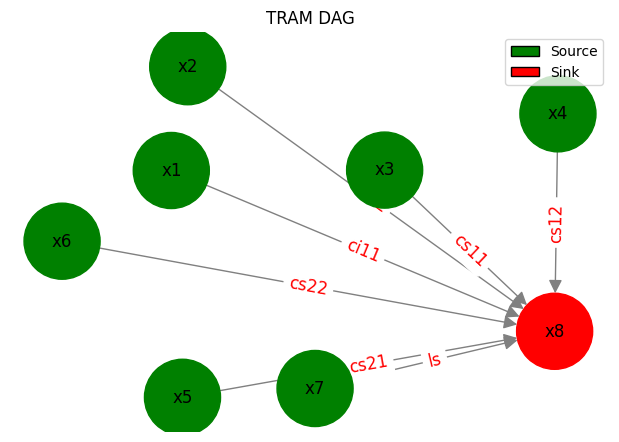

In [6]:
# --- Editable Parameters ---
variable_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
data_type={'x1':'cont','x2':'cont','x3':'cont','x4':'cont','x5':'cont','x6':'cont','x7':'cont','x8':'cont'}  # continous , images , ordinal

# x8~CI(x1,x2)+CS(x3,x4)+CS(x5,X6)+LS(X7)
interactive_adj_matrix(variable_names, data_type,experiment_dir=EXPERIMENT_DIR, seed=5)

In [7]:
adj_matrix = np.load(os.path.join(EXPERIMENT_DIR, "adj_matrix.npy"),allow_pickle=True)

# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

*************
 Model has Complex intercepts and Complex shifts, please add your Model to the modelzoo 
*************


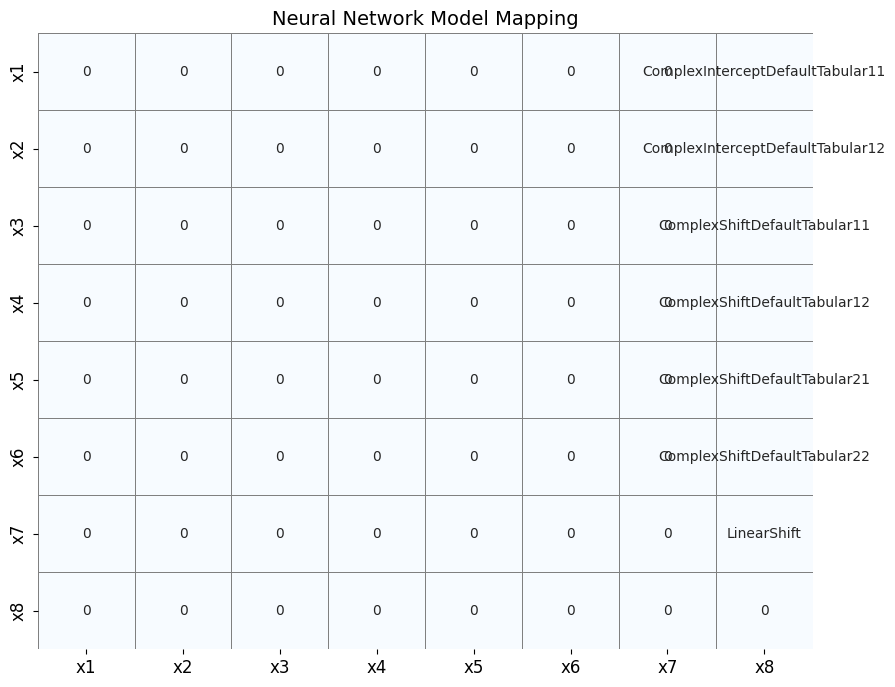

In [8]:
# check if there are Ci or Compelx shifts in the models. If yes define the modelnames
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
# nn_names_matrix[1,2]='ComplexShiftCustomTabular'
plot_nn_names_matrix(nn_names_matrix,data_type)

In [9]:
#TODO : OPTION write config to a argparser to  and args object to pass datatypes

conf_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
# write min max to conf dict
for i,node in enumerate(data_type.keys()):
    conf_dict[node]['min']=min_vals[i].tolist()   # <---- TODO add quanitle marker
    conf_dict[node]['max']=max_vals[i].tolist()
    

# write to file
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"{experiment_name}_conf.json")
with open(CONF_DICT_PATH, 'w') as f:
    json.dump(conf_dict, f, indent=4)
    
print(f"Configuration saved to {CONF_DICT_PATH}")

conf_dict

Configuration saved to /home/bule/TramDag/dev_experiment_logs/interactions/interactions_conf.json


/tmp/ipykernel_1431328/1695834966.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_dict[node]['min']=min_vals[i].tolist()   # <---- TODO add quanitle marker
/tmp/ipykernel_1431328/1695834966.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_dict[node]['max']=max_vals[i].tolist()


{'x1': {'Modelnr': 0,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 0.1023280003906143,
  'max': 1.895380529733125},
 'x2': {'Modelnr': 1,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 0.09848326169895154,
  'max': 1.9048444463462053},
 'x3': {'Modelnr': 2,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 0.10592383041862734,
  'max': 1.9012680218740785},
 'x4': {'Modelnr': 3,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 0.0972050026910846,
  'max': 

In [10]:
DEV_TRAINING=True
train_list=['x1','x2','x3','x4','x5','x6','x7','x8']#['x2']#'x1','x2']#,'x3']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 512#4112
epochs = 250# <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
learning_rate=0.1
use_scheduler =  False

In [11]:
# For each NODE 
for node in conf_dict:
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')
    
    ########################## 0. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (conf_dict[node]['node_type'] == 'source') and (conf_dict[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    MODEL_PATH, LAST_MODEL_PATH, TRAIN_HIST_PATH, VAL_HIST_PATH = model_train_val_paths(NODE_DIR)

    ########################## 2. Create Model ##############################
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=True).to(device)
    #tram_model =get_fully_specified_tram_model_hardcoded_init_weights_for_si(node, conf_dict, verbose=True).to(device)

    _, ordered_transformation_terms_in_h, _=ordered_parents(node, conf_dict)
    ########################## 3. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=batch_size, verbose=True)

    ########################## 4. Load Model & History ######################
    if os.path.exists(MODEL_PATH) and os.path.exists(TRAIN_HIST_PATH) and os.path.exists(VAL_HIST_PATH):
        print("Existing model found. Loading weights and history...")
        tram_model.load_state_dict(torch.load(MODEL_PATH))

        with open(TRAIN_HIST_PATH, 'r') as f:
            train_loss_hist = json.load(f)
        with open(VAL_HIST_PATH, 'r') as f:
            val_loss_hist = json.load(f)

        start_epoch = len(train_loss_hist)
        best_val_loss = min(val_loss_hist)
        print(f"Continuing training from epoch {start_epoch}...")
    else:
        print("No existing model found. Starting fresh...")
        train_loss_hist, val_loss_hist = [], []
        start_epoch = 0
        best_val_loss = float('inf')

    # Skip if already trained
    if start_epoch >= epochs:
        print(f"Node {node} already trained for {epochs} epochs. Skipping.")
        continue

    ########################## 5. Optimizer & Scheduler ######################.
    
    ## <---------- TODO use standard SGD and no scheduler
    # optimizer = torch.optim.AdamW(tram_model.parameters(), lr=0.1, eps=1e-8, weight_decay=1e-2)
    # optimizer = torch.optim.AdamW(
    # tram_model.parameters(),
    # lr=1e-3,           # ← two orders of magnitude smaller
    # eps=1e-8,
    # weight_decay=1e-2
    # )   
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=1e-3, total_steps=epochs * len(train_loader),pct_start=0.1, anneal_strategy="cos"       # pick your sweet-spot

    else:
        scheduler = None

    ########################## 6. Min/Max Tensor #############################
    min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    ########################## 7. Training Loop ##############################

    if DEV_TRAINING:
        train_val_loop(
            start_epoch,
            epochs,
            tram_model,
            train_loader,
            val_loader,
            train_loss_hist,
            val_loss_hist,
            best_val_loss,
            device,
            optimizer,
            use_scheduler,
            scheduler,
            min_max,
            NODE_DIR,
            ordered_transformation_terms_in_h,
            save_linear_shifts=True
        )


----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
Existing model found. Loading weights and history...
Continuing training from epoch 250...
Node x1 already trained for 250 epochs. Skipping.

----*----------*-------------*--------------- Node: x2 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
Existing model found. Loading weights and history...
Continuing training from epoch 250...
Node x2 already trained for 250 epochs. Skipping.

----*----------*-------------*-----------

# 6 Inspect Training

## 6.1 Loss vs epochs

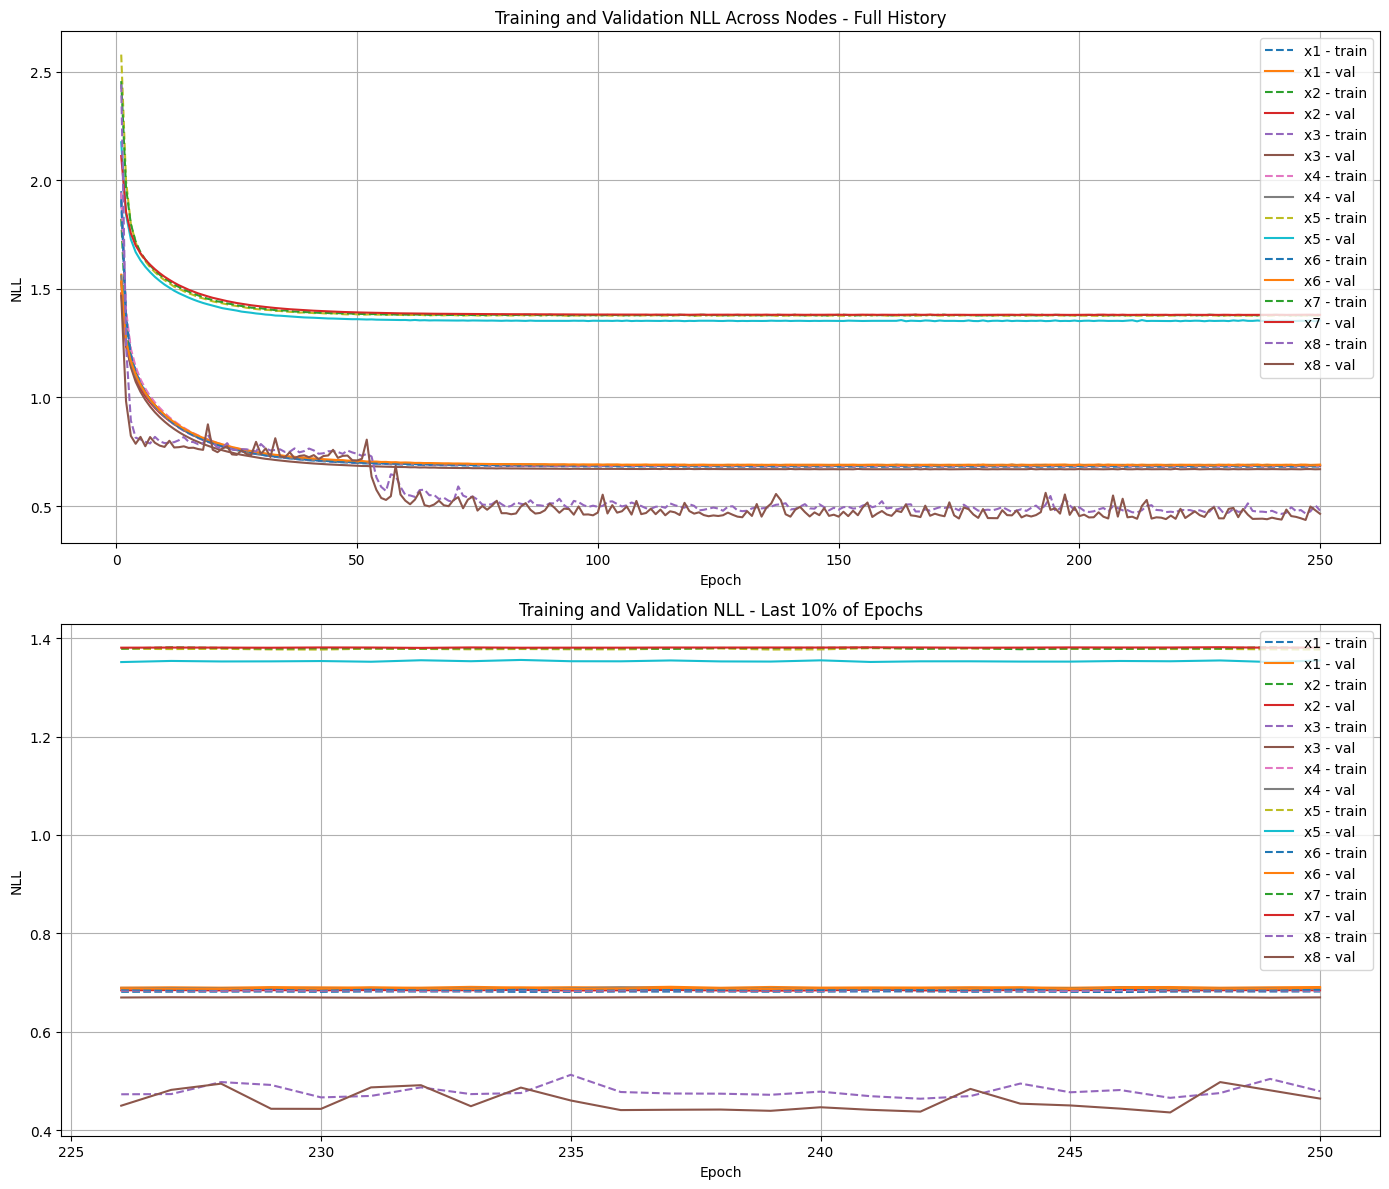

In [12]:
show_training_history(conf_dict,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--


h() for  x1:   0%|          | 0/1000 [00:00<?, ?it/s]


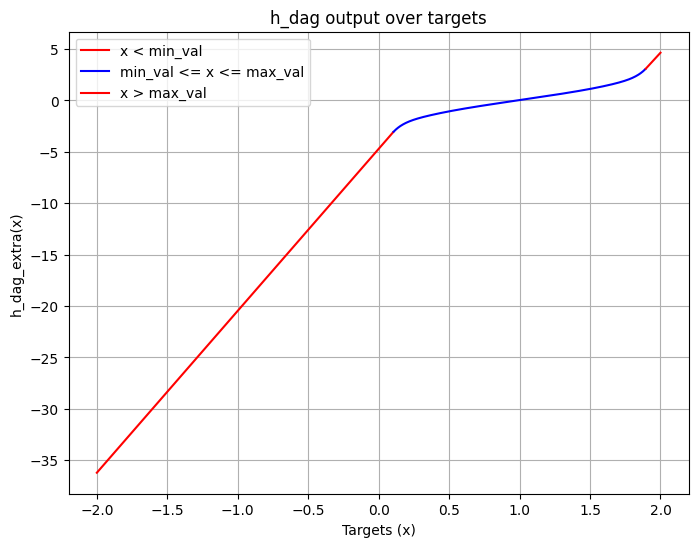


----*----------*-------------*--------Inspect TRAFO Node: x2 ------------*-----------------*-------------------*--


h() for  x2:   0%|          | 0/1000 [00:00<?, ?it/s]


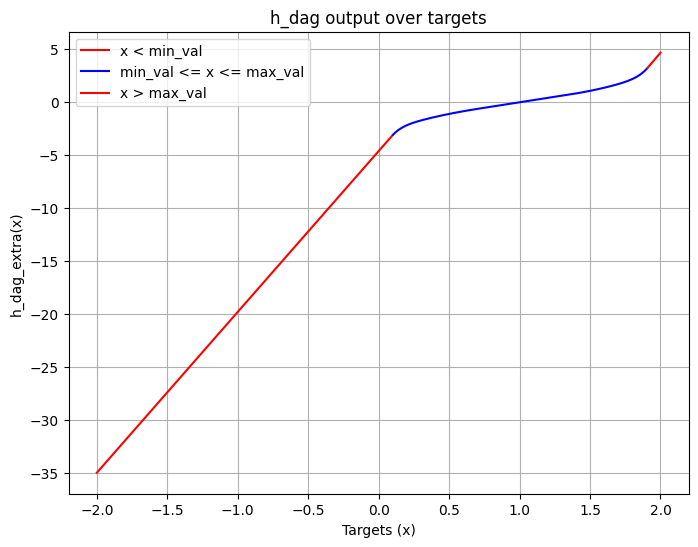


----*----------*-------------*--------Inspect TRAFO Node: x3 ------------*-----------------*-------------------*--


h() for  x3:   0%|          | 0/1000 [00:00<?, ?it/s]


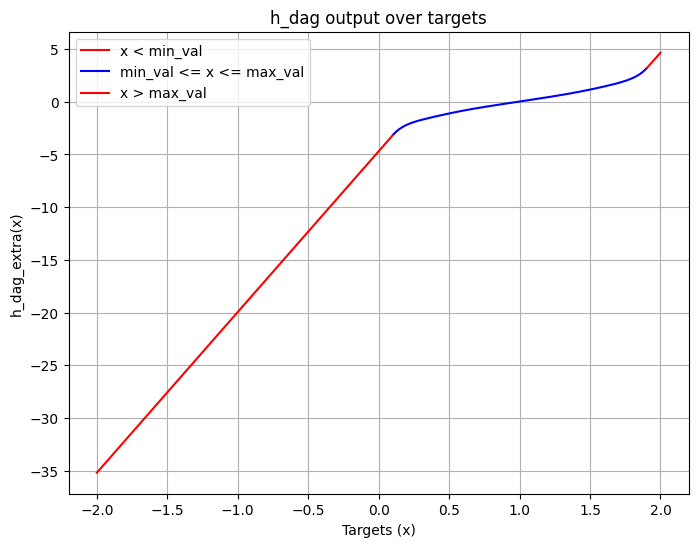


----*----------*-------------*--------Inspect TRAFO Node: x4 ------------*-----------------*-------------------*--


h() for  x4:   0%|          | 0/1000 [00:00<?, ?it/s]


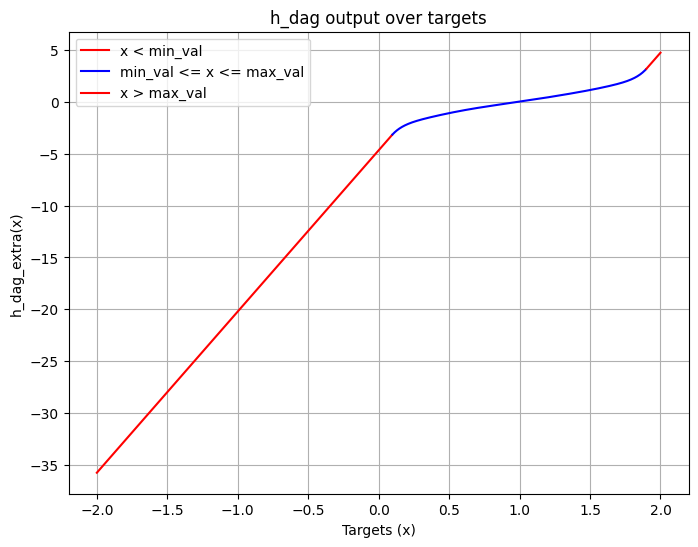


----*----------*-------------*--------Inspect TRAFO Node: x5 ------------*-----------------*-------------------*--


h() for  x5:   0%|          | 0/1000 [00:00<?, ?it/s]


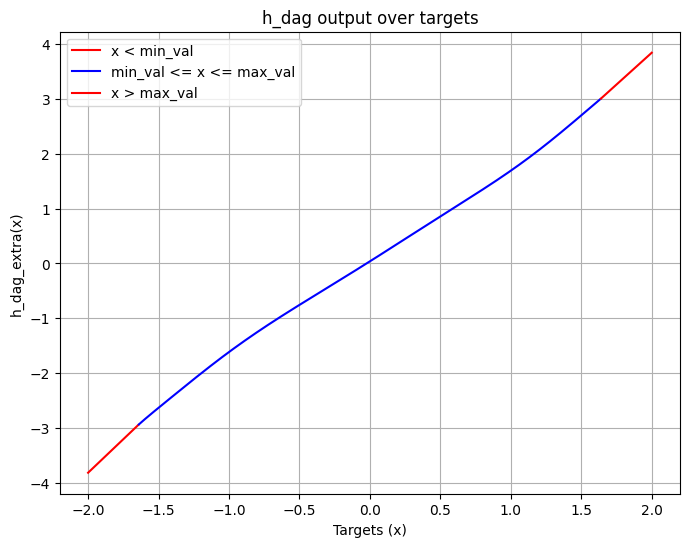


----*----------*-------------*--------Inspect TRAFO Node: x6 ------------*-----------------*-------------------*--


h() for  x6:   0%|          | 0/1000 [00:00<?, ?it/s]


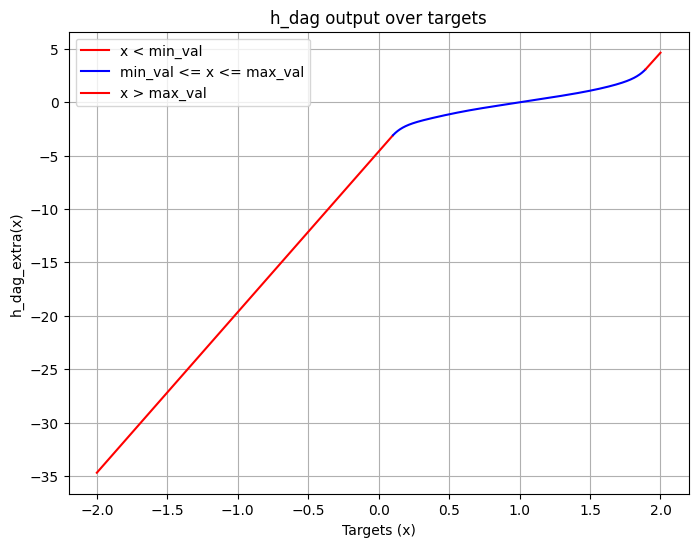


----*----------*-------------*--------Inspect TRAFO Node: x7 ------------*-----------------*-------------------*--


h() for  x7:   0%|          | 0/1000 [00:00<?, ?it/s]


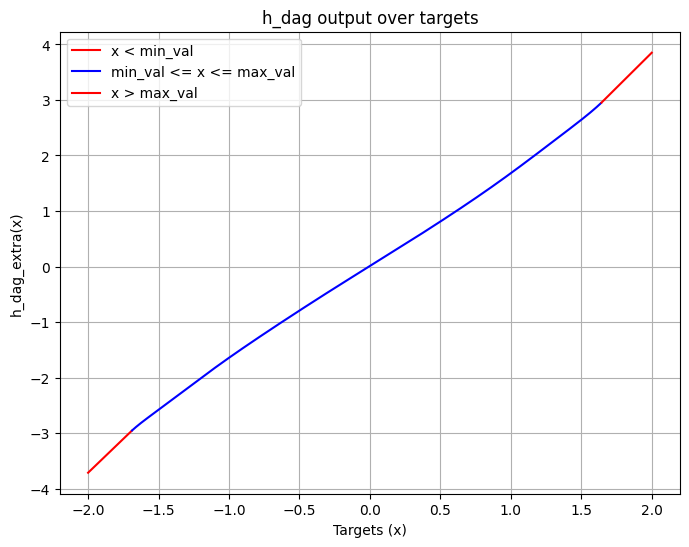


----*----------*-------------*--------Inspect TRAFO Node: x8 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [13]:
show_hdag_for_source_nodes(conf_dict,EXPERIMENT_DIR,device=device,xmin_plot=-2,xmax_plot=2) # TODO for other nodes funciton


----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


Val loader (x1): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


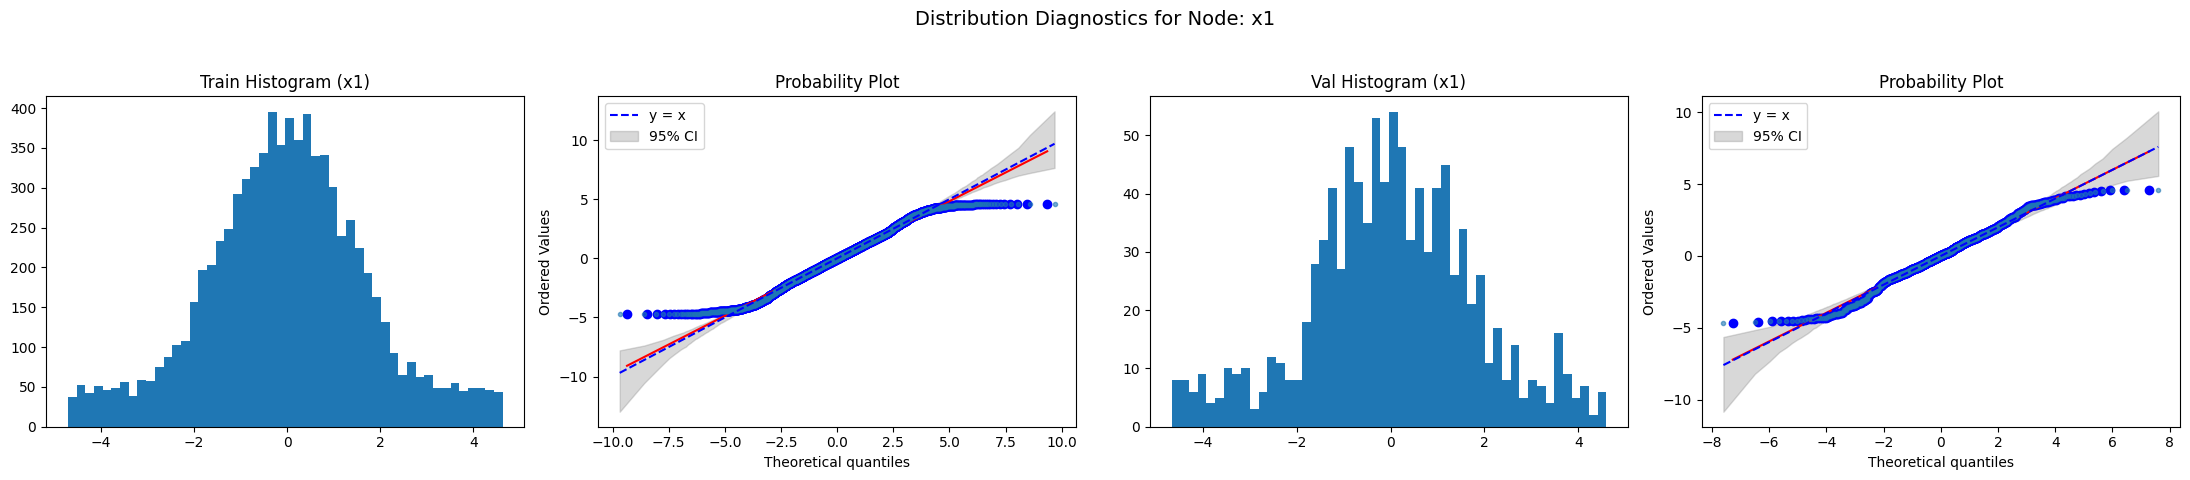


----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


Val loader (x2): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


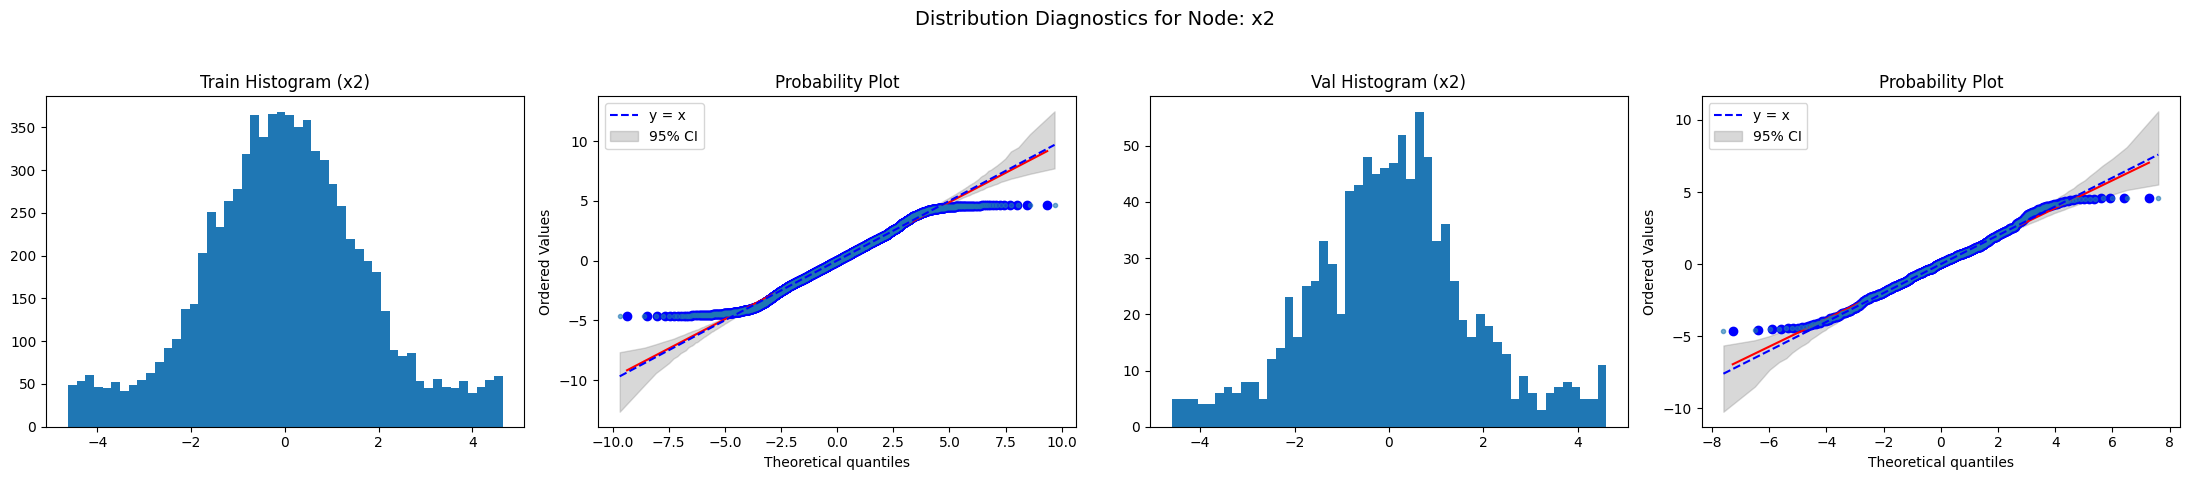


----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--


Val loader (x3): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


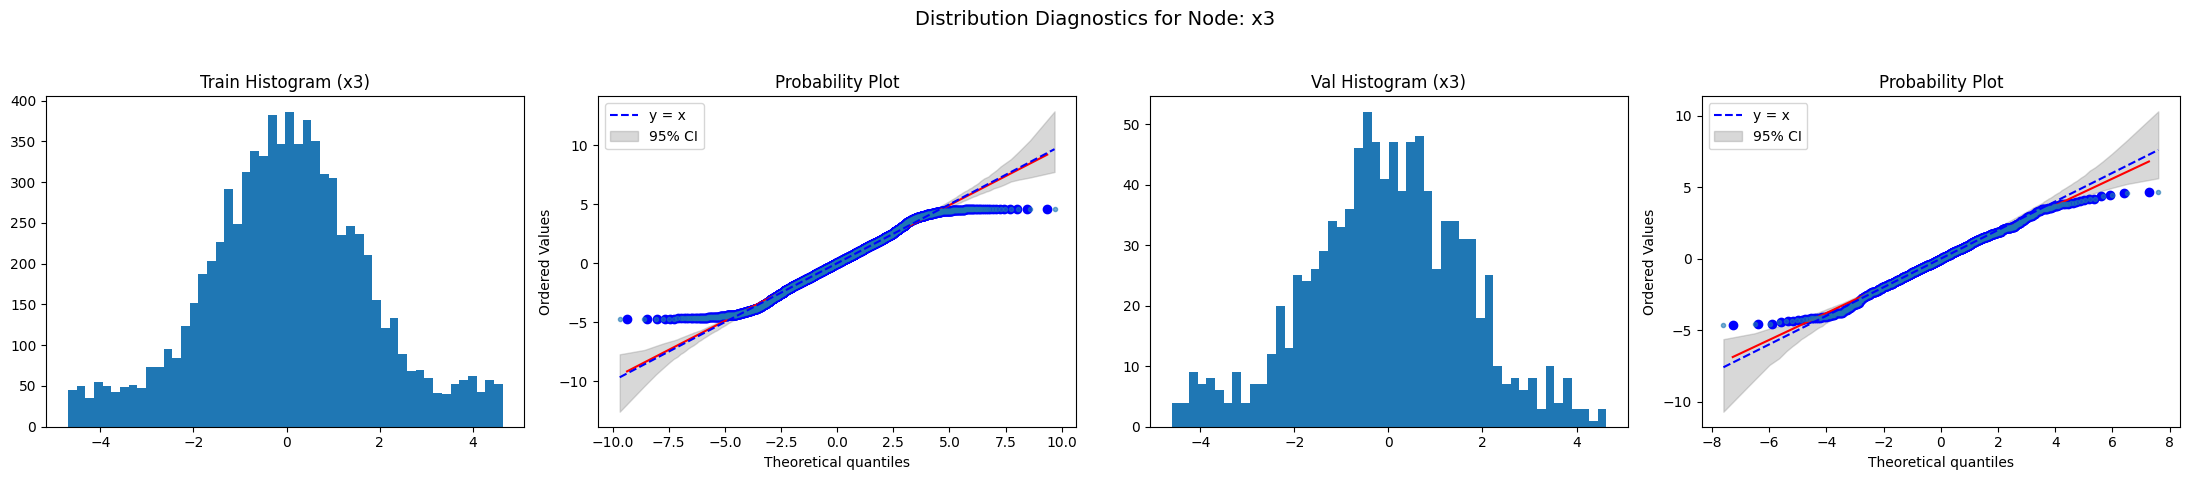


----*----------*-------------*--------h(data) should be standard logistic: x4 ------------*-----------------*-------------------*--


Val loader (x4): 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


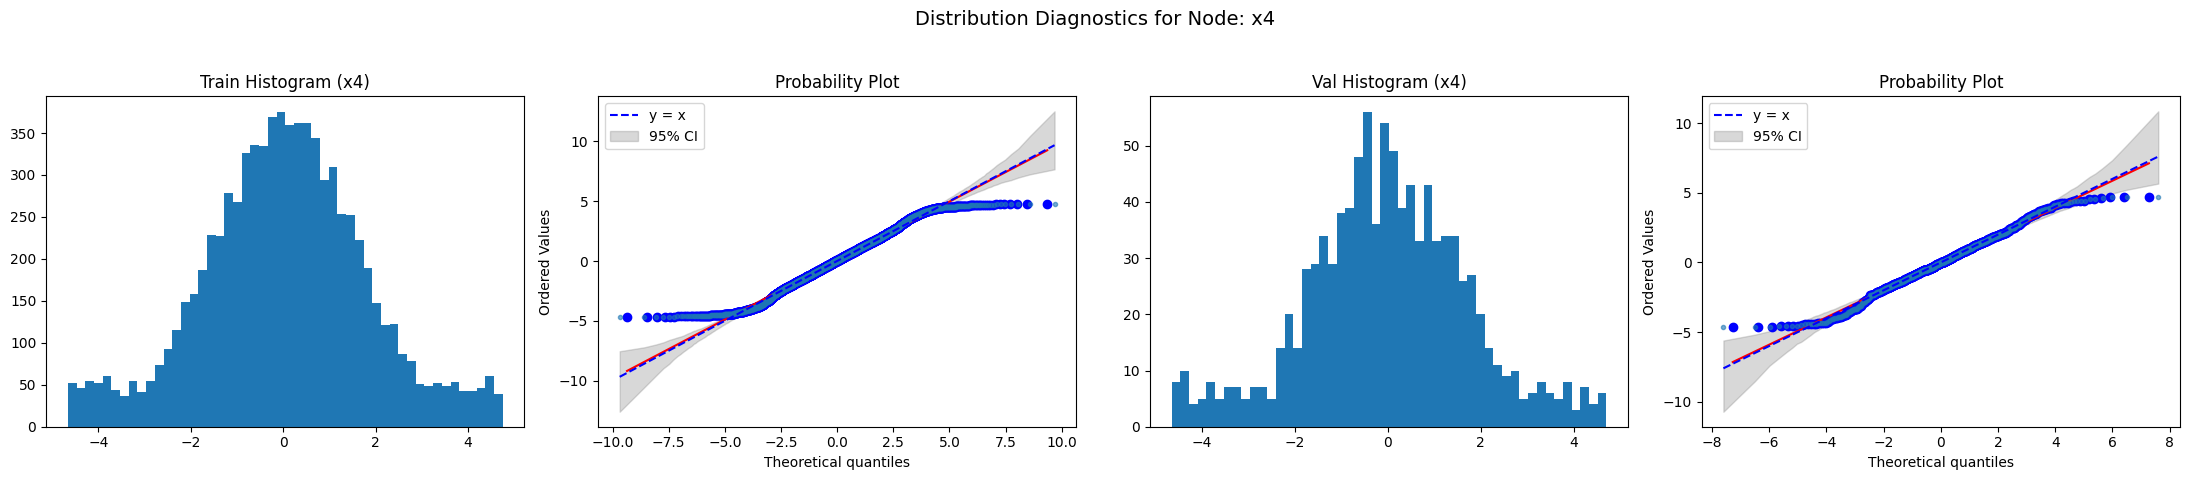


----*----------*-------------*--------h(data) should be standard logistic: x5 ------------*-----------------*-------------------*--


Val loader (x5): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


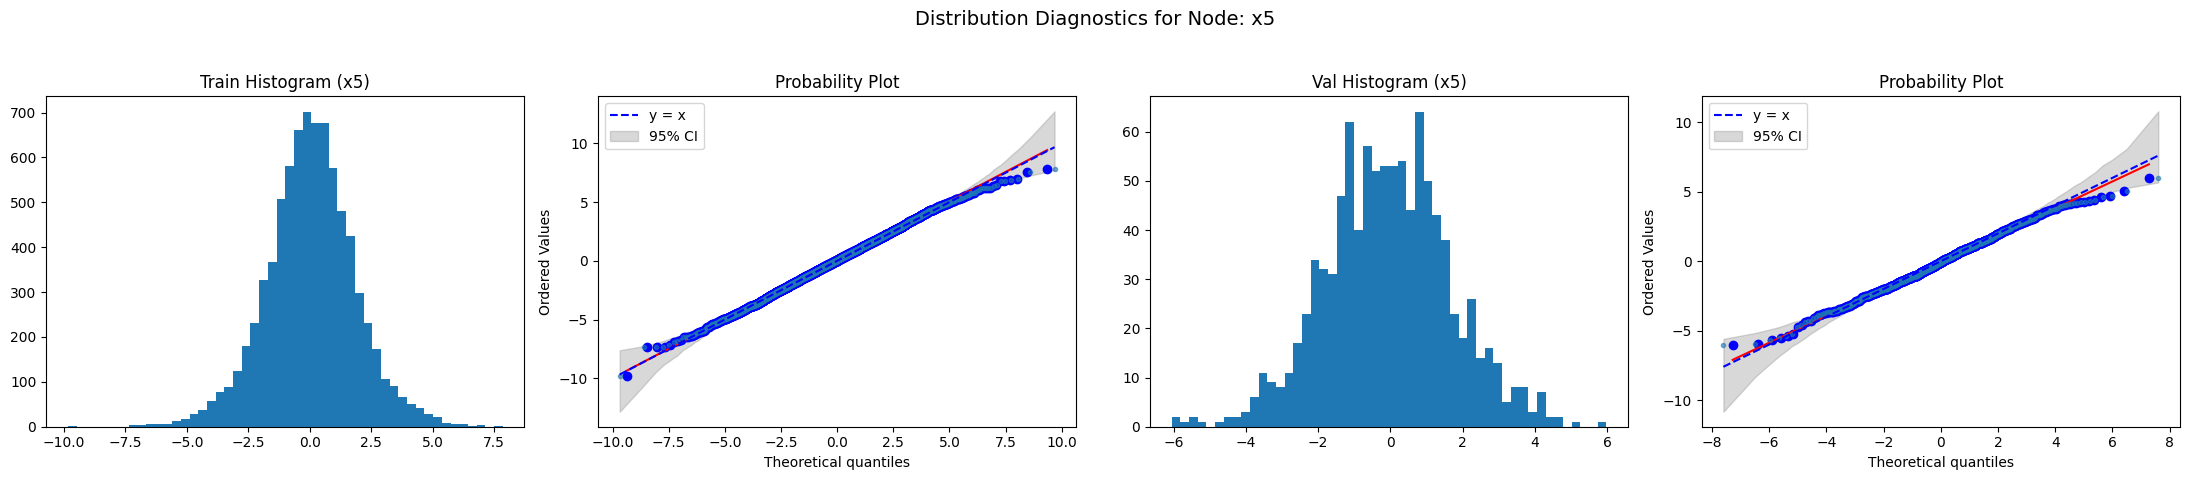


----*----------*-------------*--------h(data) should be standard logistic: x6 ------------*-----------------*-------------------*--


Val loader (x6): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


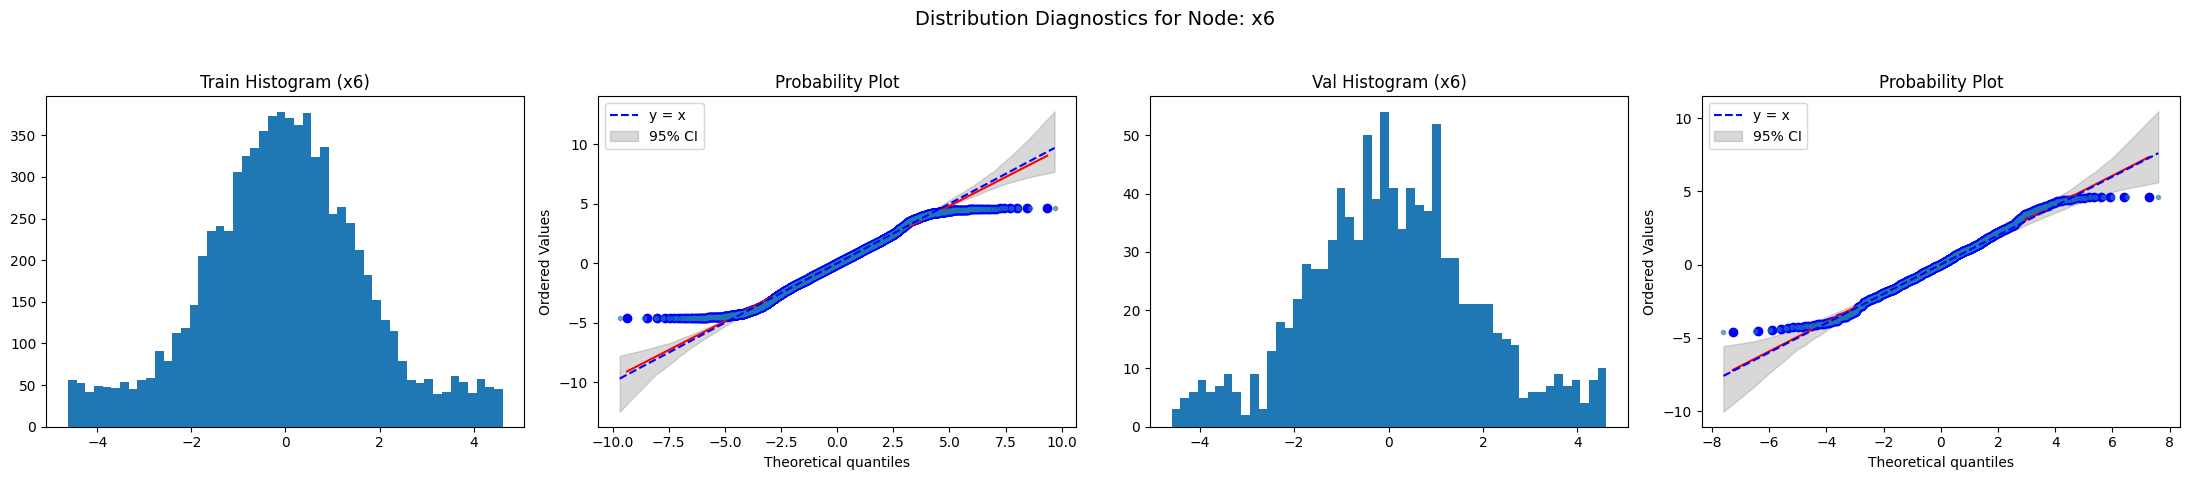


----*----------*-------------*--------h(data) should be standard logistic: x7 ------------*-----------------*-------------------*--


Val loader (x7): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


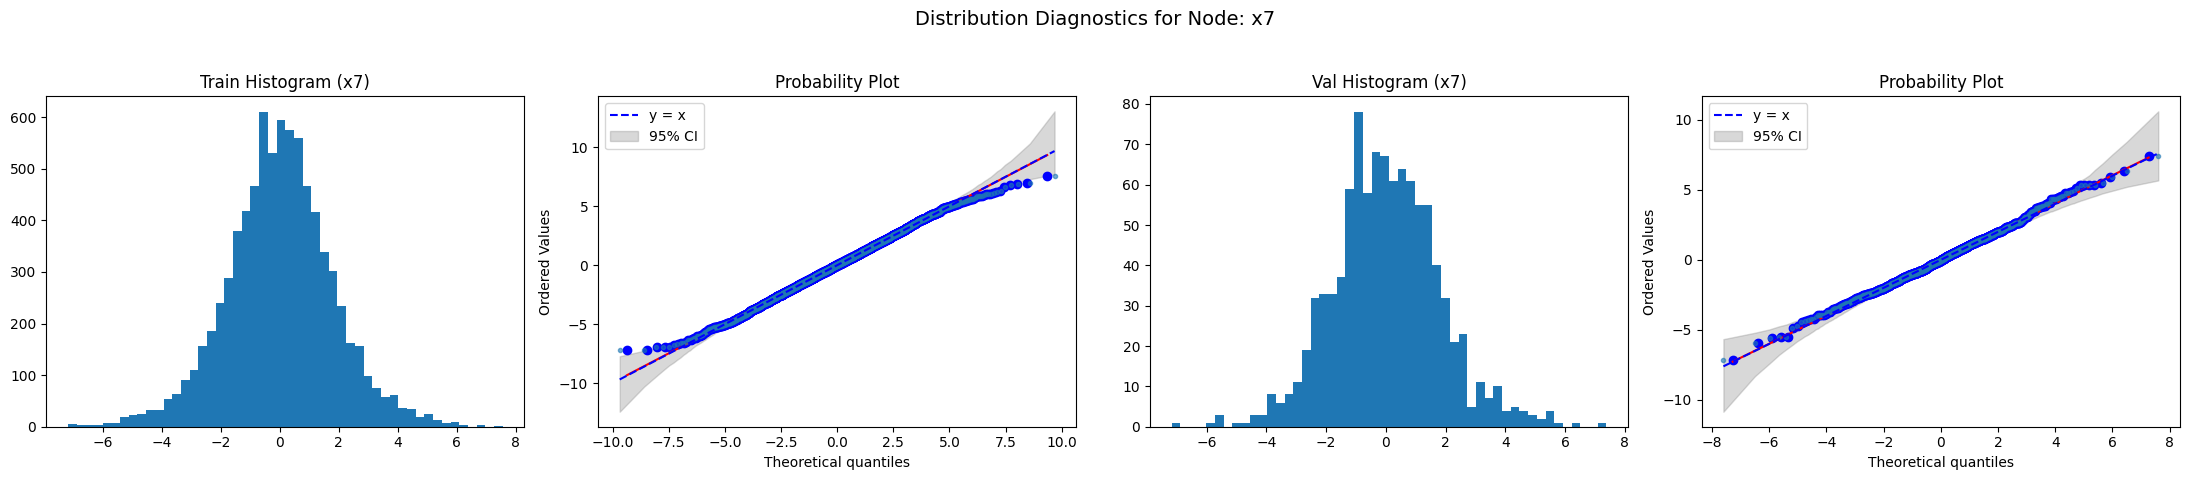


----*----------*-------------*--------h(data) should be standard logistic: x8 ------------*-----------------*-------------------*--


Val loader (x8): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


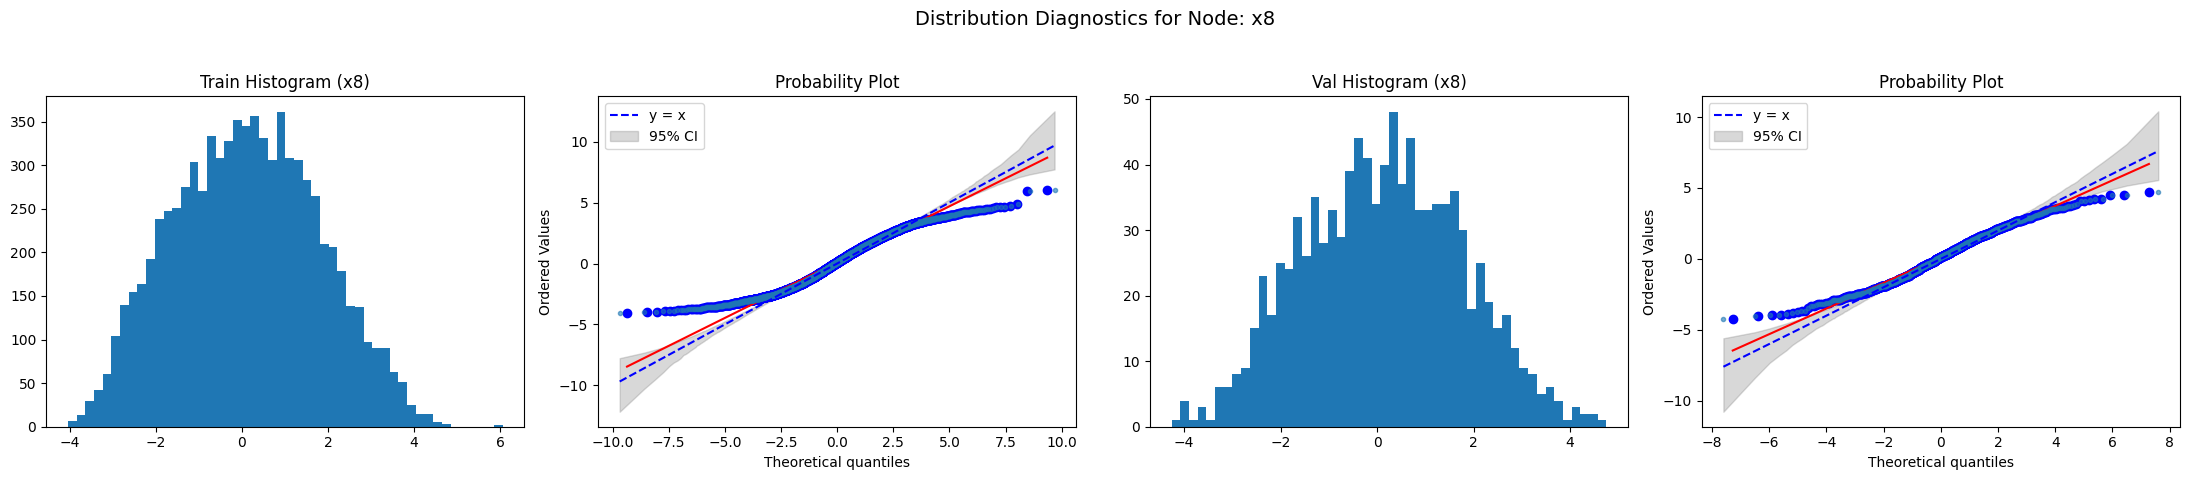

In [14]:
inspect_trafo_standart_logistic(conf_dict,EXPERIMENT_DIR,train_df,val_df,device,verbose=False)

### Coefficient estimates


---- check CS of x1 ----
Node type: source — skipping.

---- check CS of x2 ----
Node type: source — skipping.

---- check CS of x3 ----
Node type: source — skipping.

---- check CS of x4 ----
Node type: source — skipping.

---- check CS of x5 ----
Node type: source — skipping.

---- check CS of x6 ----
Node type: source — skipping.

---- check CS of x7 ----
Node type: source — skipping.

---- check CS of x8 ----

Module 0: ComplexShiftDefaultTabular
ComplexShiftDefaultTabular(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=False)
)
  expects input shape = (batch_size, 2)


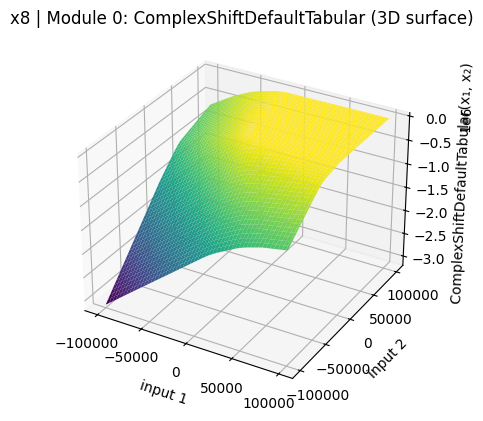


Module 1: ComplexShiftDefaultTabular
ComplexShiftDefaultTabular(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=False)
)
  expects input shape = (batch_size, 2)


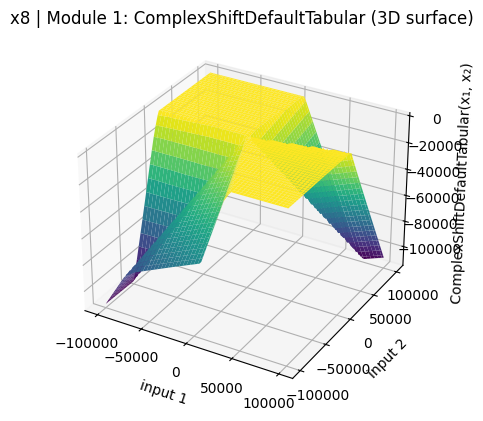


Module 2: LinearShift
LinearShift(
  (fc): Linear(in_features=1, out_features=1, bias=False)
)
  LinearShift weights:
tensor([[-6.4505]], device='cuda:0')


In [15]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # enable 3D plotting

# --- Your existing setup ---
verbose    = False
batch_size = 4112
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# this x is only for overlaying your target curve in 2D plots
x1d = torch.linspace(-1, 1, steps=1000).unsqueeze(1).to(device)  # (1000, 1)
def f(x):
    return 0.75 * np.arctan(5 * (x + 0.12))

for node in conf_dict:
    print(f"\n---- check CS of {node} ----")
    if conf_dict[node]['node_type'] == 'source':
        print("Node type: source — skipping.")
        continue

    # load your model
    NODE_DIR   = os.path.join(EXPERIMENT_DIR, node)
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=verbose).to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()


    for i, module in enumerate(tram_model.nn_shift):
        name = module.__class__.__name__
        print(f"\nModule {i}: {name}")
        print(module)

        if name == 'LinearShift':
            print("  LinearShift weights:")
            print(module.fc.weight.data)
            continue

        # read wanted input dims
        in_feats = module.fc1.in_features
        print(f"  expects input shape = (batch_size, {in_feats})")

        # 2-input case → 3D surface plot
        if in_feats == 2:
            N = 100
            a = torch.linspace(-100_000, 100_000, steps=N, device=device)
            b = torch.linspace(-100_000, 100_000, steps=N, device=device)
            A, B = torch.meshgrid(a, b, indexing='ij')       # both (N, N)
            grid = torch.stack([A, B], dim=-1).view(-1, 2)   # (N*N, 2)

            with torch.no_grad():
                Y = module(grid).view(N, N).cpu().numpy()    # back to (N, N)

            A_np = A.cpu().numpy()
            B_np = B.cpu().numpy()

            fig = plt.figure()
            ax  = fig.add_subplot(111, projection='3d')
            ax.plot_surface(A_np, B_np, Y, cmap='viridis', edgecolor='none')
            ax.set_xlabel('input 1')
            ax.set_ylabel('input 2')
            ax.set_zlabel(f'{name}(x₁, x₂)')
            ax.set_title(f"{node} | Module {i}: {name} (3D surface)")
            plt.show()

        # 1-input case → 2D scatter
        else:
            N = 1000
            lin = torch.linspace(-1, 1, steps=N, device=device)
            dummy = lin.unsqueeze(1).repeat(1, in_feats)      # (N, in_feats)

            with torch.no_grad():
                y = module(dummy).squeeze().cpu().numpy()

            plt.figure()
            plt.scatter(dummy[:, 0].cpu().numpy(), y, s=5, label=f"{name} output")
            # overlay target
            plt.scatter(x1d.cpu().numpy(), -f(x1d.cpu().numpy()), c="red", s=5, label="target")
            plt.xlabel("input value")
            plt.ylabel("output value")
            plt.title(f"{node} | Module {i}: {name} (2D)")
            plt.legend()
            plt.show()


# 7. Sample from Graph

In [16]:
sample_full_dag_chandru(conf_dict,
                            EXPERIMENT_DIR,
                            device,
                            n= 10_000,
                            batch_size = 1,
                            delete_all_previously_sampled=True,
                            verbose=True)     

Directory does not exist: /home/bule/TramDag/dev_experiment_logs/interactions/x1/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/interactions/x2/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/interactions/x3/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/interactions/x4/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/interactions/x5/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/interactions/x6/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/interactions/x7/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/interactions/x8/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/interactions/x1/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by 

h() for samples in  x1: 100%|██████████| 10000/10000 [00:01<00:00, 5320.70it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:31<00:00, 319.07it/s]



----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/interactions/x2/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x2: 100%|██████████| 10000/10000 [00:01<00:00, 5653.44it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 325.99it/s]



----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/interactions/x3/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x3: 100%|██████████| 10000/10000 [00:01<00:00, 5660.89it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 327.39it/s]



----*----------*-------------*--------Sample Node: x4 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/interactions/x4/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x4: 100%|██████████| 10000/10000 [00:01<00:00, 5823.01it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 324.31it/s]



----*----------*-------------*--------Sample Node: x5 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/interactions/x5/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x5: 100%|██████████| 10000/10000 [00:01<00:00, 5705.44it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 330.85it/s]



----*----------*-------------*--------Sample Node: x6 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/interactions/x6/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x6: 100%|██████████| 10000/10000 [00:01<00:00, 5270.89it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:31<00:00, 317.54it/s]



----*----------*-------------*--------Sample Node: x7 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/interactions/x7/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x7: 100%|██████████| 10000/10000 [00:01<00:00, 5703.82it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:31<00:00, 322.19it/s]
/home/bule/TramDag/utils/sampling_tram_data.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_list.append(torch.tensor(tensor))  # ensure tensor type



----*----------*-------------*--------Sample Node: x8 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/interactions/x8/sampling
-- sampled latents
>>> TRAM MODEL:
 TramModel(
  (nn_int): ComplexInterceptDefaultTabular(
    (fc1): Linear(in_features=2, out_features=8, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=8, out_features=8, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=8, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0-1): 2 x ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=2, out_features=32, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=32, out_features=32, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=32, out_features=1, bias=False)
    )
    (2): LinearShift(
      (fc): Linear(in_features=1, out_features=1, bias=False)
    )
  )
)
-- loaded modelweights


h() for samples in  x8:   0%|          | 0/10000 [00:00<?, ?it/s]


ValueError: Unknown transformation term: x1

## 7.3 Inspect Sampling

In [ ]:
show_samples_vs_true(test_df,conf_dict,EXPERIMENT_DIR,rootfinder='chandrupatla')

## 7.4 Intervention

In [ ]:
def f(x):
    return -0.3*x  

intervention_df=dgp(10_000, doX=[-1.0, None, None], seed=-1)
sns.pairplot(intervention_df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
sample_full_dag_chandru(conf_dict,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={'x1':-1.0},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True)

In [ ]:
show_samples_vs_true(intervention_df,conf_dict,EXPERIMENT_DIR,rootfinder='chandrupatla')